In [4]:
%matplotlib inline

import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [5]:
data = np.load('StarsWithRadialVelocity.npy')

In [6]:
data_cols = ['l', 'b','ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity',
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
             'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error',
             'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
             'AccretedLabel'
            ]

In [7]:
data = pd.DataFrame(data, columns=data_cols)

In [8]:
data.head()

,l,b,ra,dec,pmra,pmdec,parallax,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_error,pmdec_error,parallax_error,radial_velocity_error,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,AccretedLabel
0,18.947771,17.087326,261.281075,-4.105546,0.304014,-2.012651,0.443537,44.472788,14.384683,14.678857,13.931516,0.091557,0.091557,0.044116,9.908263,0.000611,0.003929,0.003929,0.0
1,-4.978819,-41.542610,315.656827,-45.372252,15.768343,-16.975898,1.369992,-120.045033,12.405884,12.633657,12.030871,0.087001,0.087001,0.042780,2.036502,0.000342,0.002105,0.002105,0.0
2,-137.539419,-47.311996,60.814237,-25.789371,5.542696,9.388474,0.597262,83.063864,14.347357,14.619976,13.923520,0.091365,0.091365,0.044055,9.917098,0.000602,0.003861,0.003861,0.0
3,-68.315598,-32.353069,71.998054,-78.933526,14.320530,-13.669455,0.862436,-106.062495,14.062039,14.311761,13.648176,0.090130,0.090130,0.043668,7.792049,0.000544,0.003407,0.003407,0.0
4,85.879721,-52.988838,351.547535,3.638489,2.937268,5.109022,1.510236,-23.143291,14.677980,15.082906,14.107460,0.093275,0.093275,0.044678,11.110764,0.000683,0.004529,0.004529,0.0


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
# What columns to use?
use_cols = ['l', 'b','parallax','pmra','pmdec']
# Make the design matrix
X = data[use_cols].values
Y = (data['radial_velocity']).values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X[1:500000], Y[1:500000],
                                                    test_size = 0.2,
                                                    random_state=42)

In [27]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(399999, 5)
(399999,)
There are -1438120.796128343 stars in the training set

(100000, 5)
(100000,)
There are -351178.2908281403 stars in the test set


In [28]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [29]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


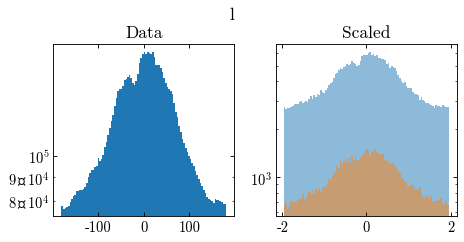

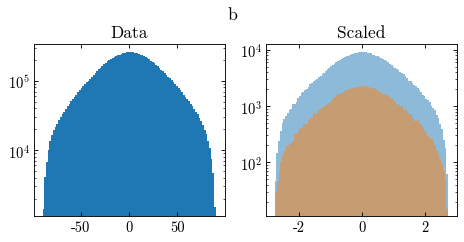

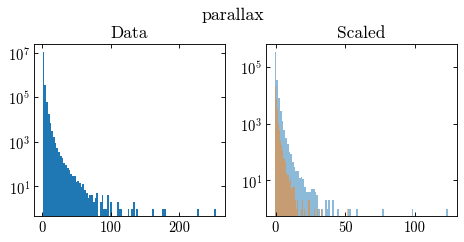

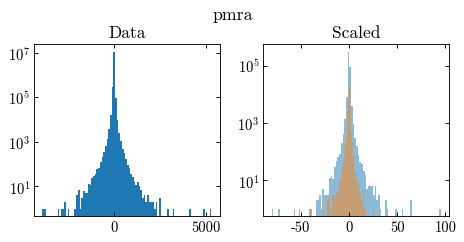

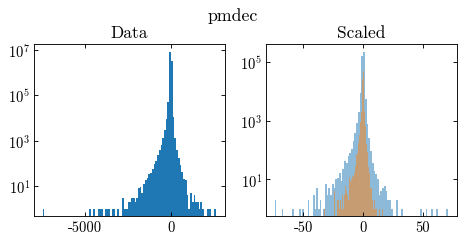

In [30]:
#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(data[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [32]:
MyModel = Sequential()
MyModel.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=1))
#using tanh activation function in the last layer
#MyModel.compile(loss='mean_squared_error',
               # optimizer='adam'
              # )
MyModel.compile(loss='mean_squared_error',
                optimizer='adam'
               )

In [33]:
MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = MyModel.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=8192
                     )

Train on 319999 samples, validate on 80000 samples
Epoch 1/100
319999/319999 [==============================] - 3s 8us/step - loss: 4720.9648 - val_loss: 4599.7438
Epoch 2/100
319999/319999 [==============================] - 2s 8us/step - loss: 4581.2892 - val_loss: 4449.8560
Epoch 3/100
319999/319999 [==============================] - 2s 8us/step - loss: 4385.9448 - val_loss: 4235.3994
Epoch 4/100
319999/319999 [==============================] - 2s 8us/step - loss: 4206.2534 - val_loss: 4147.5011
Epoch 5/100
319999/319999 [==============================] - 2s 8us/step - loss: 4127.3126 - val_loss: 4079.3218
Epoch 6/100
319999/319999 [==============================] - 2s 7us/step - loss: 4074.5124 - val_loss: 4038.2496
Epoch 7/100
319999/319999 [==============================] - 2s 8us/step - loss: 4052.1594 - val_loss: 4037.6247
Epoch 8/100
319999/319999 [==============================] - 2s 8us/step - loss: 4028.7351 - val_loss: 4003.6005
Epoch 9/100
319999/319999 [==================

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


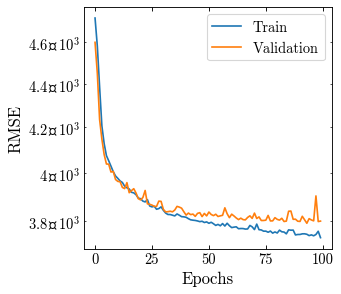

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['Train', 'Validation'])
plt.show()

In [36]:
# predict the scores for the test set, then histogram them based on the real labels
test_preds = MyModel.predict(X_test)

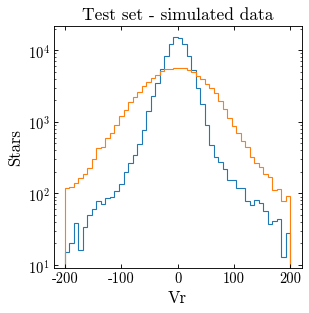

In [37]:
plt.hist(test_preds, bins=50, range=(-200,200), histtype='step')
plt.hist(y_test, bins=50, range=(-200,200), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()

Text(0, 0.5, 'Vr real')

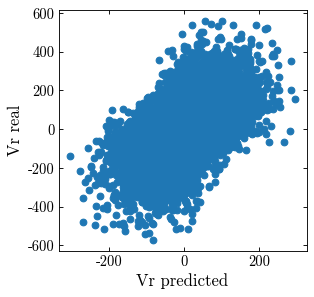

In [38]:
plt.scatter(test_preds,y_test)
plt.xlabel('Vr predicted')
plt.ylabel('Vr real')